In [1]:
#import libraries
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans





# Set display options
pd.set_option('display.max_columns', None)  # None means unlimited
pd.set_option('display.max_rows', None)  # None means unlimited
warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def wrangle(filepath):
    # Read csv file into dataframe
    df = pd.read_csv(filepath)
    
    # Remove duplicated values
    df.drop_duplicates(subset="id", inplace=True)
    
    # Convert date to datetime and split
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    
    # Drop date and id column
    df.drop(["date", "id"], axis=1, inplace=True)

    # Drop multicolinear variables
    df.drop(["sqft_above", "sqft_above"], axis=1, inplace=True)
    
    # Add other data wrangling steps here if needed
    
    return df


In [3]:
df = wrangle(r"C:\Users\eakli\Downloads\task\ecole\house-pricing-prediction\apartment-hunter\data\raw\kc_house_data.csv")

In [4]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [5]:
df.shape

(21436, 21)

In [6]:
df["price"].describe().apply("{0:,.0f}".format)

count       21,436
mean       540,529
std        367,689
min         75,000
25%        322,150
50%        450,000
75%        645,000
max      7,700,000
Name: price, dtype: object

<Axes: xlabel='price', ylabel='Count'>

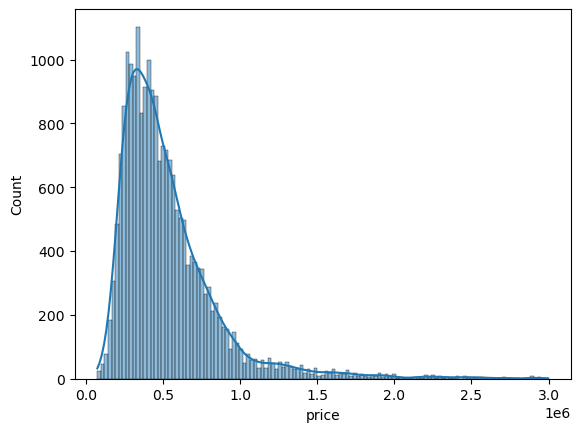

In [32]:
price_less_3e6 = df[df["price"] < 3_000_000]
price_less_3e6["sqft_living"].describe().apply("{0:,.0f}".format)
price_less_3e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_less_3e6["price"], kde=True)

(21238, 21)


count       21,238
mean       519,694
std        287,813
min         75,000
25%        320,000
50%        450,000
75%        635,438
max      2,000,000
Name: price, dtype: object

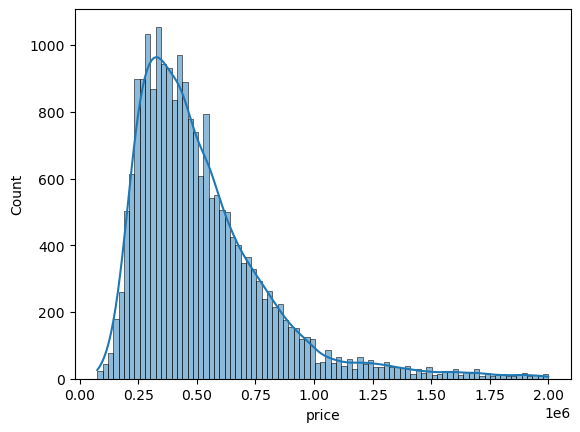

In [50]:
price_equals_less_2e6 = df[df["price"] <= 2_000_000]
price_equals_less_2e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_2e6["price"], kde=True)

print(price_equals_less_2e6.shape)
price_equals_less_2e6["price"].describe().apply("{0:,.0f}".format)



(19979, 21)


count       19,979
mean       467,931
std        196,437
min         75,000
25%        314,950
50%        435,000
75%        594,000
max      1,000,000
Name: price, dtype: object

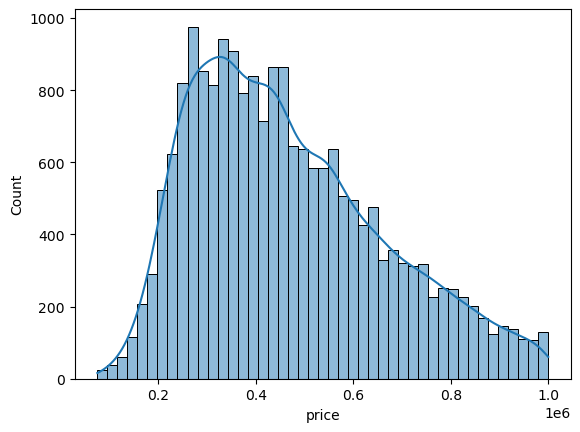

In [46]:
price_equals_less_1e6 = df[df["price"] <= 1_000_000]
price_equals_less_1e6["sqft_living"].describe().apply("{0:,.0f}".format)
# price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


sns.histplot(price_equals_less_1e6["price"], kde=True)
print(price_equals_less_1e6.shape)

price_equals_less_1e6["price"].describe().apply("{0:,.0f}".format)


(1457, 21)


count        1,457
mean     1,536,025
std        629,958
min      1,000,750
25%      1,150,000
50%      1,325,000
75%      1,691,000
max      7,700,000
Name: price, dtype: object

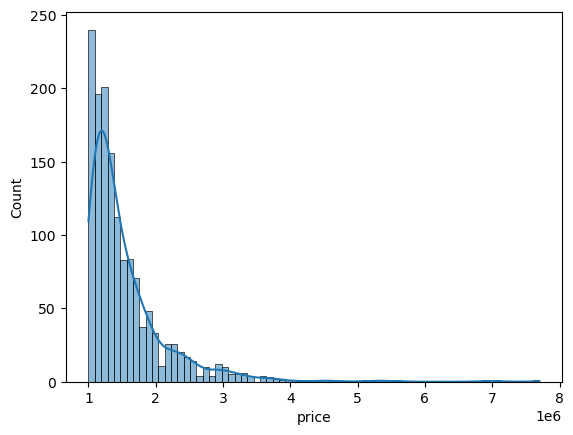

In [51]:
# Subset the dataset for houses priced above 1 million dollars
df_above_1m = df[df['price'] > 1_000_000]


sns.histplot(df_above_1m["price"], kde=True)
print(df_above_1m.shape)

df_above_1m["price"].describe().apply("{0:,.0f}".format)

(12300, 21)


count     12,300
mean     338,517
std       90,983
min       75,000
25%      269,000
50%      340,000
75%      415,000
max      499,990
Name: price, dtype: object

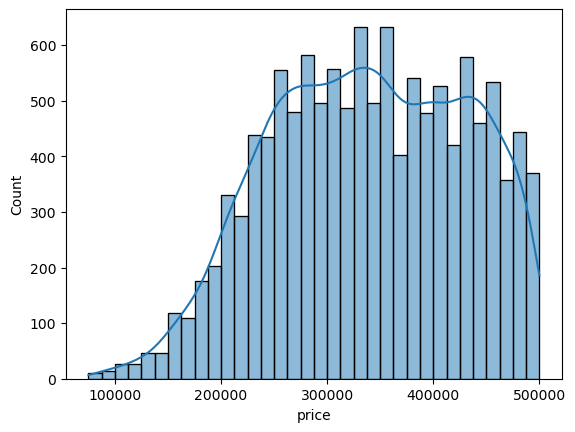

In [52]:
price_less_500K = df[df["price"] < 500_000]

price_less_500K["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_less_500K["price"], kde=True)
print(price_less_500K.shape)
price_less_500K["price"].describe().apply("{0:,.0f}".format)

(7679, 21)


count        7,679
mean       675,223
std        131,677
min        500,000
25%        562,500
50%        649,950
75%        765,500
max      1,000,000
Name: price, dtype: object

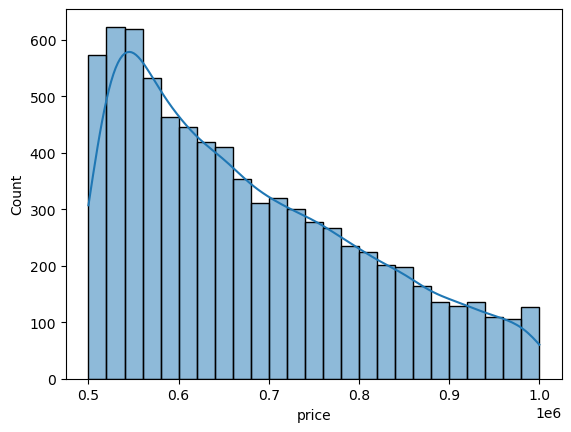

In [53]:
price_btwn_500K_and_1m = df[(df["price"] >= 500_000)  &  (df["price"] <= 1e6)]

price_btwn_500K_and_1m["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_btwn_500K_and_1m["price"], kde=True)
print(price_btwn_500K_and_1m.shape)
price_btwn_500K_and_1m["price"].describe().apply("{0:,.0f}".format)

(50, 21)


count           50
mean     3,819,715
std      1,088,118
min      3,000,000
25%      3,176,562
50%      3,397,500
75%      3,837,500
max      7,700,000
Name: price, dtype: object

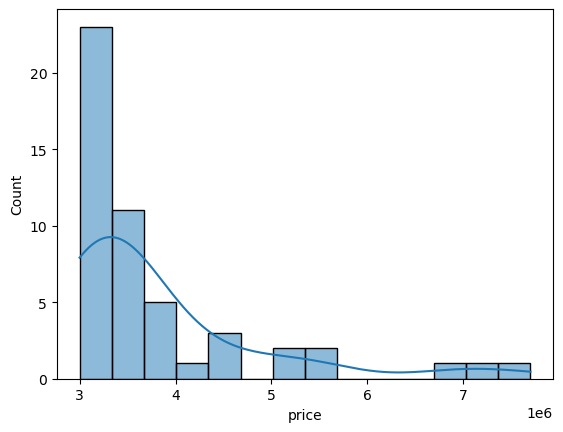

In [48]:
price_over_3e6 = df[df["price"] >= 3_000_000]
price_over_3e6["sqft_living"].describe().apply("{0:,.0f}".format)


sns.histplot(price_over_3e6["price"], kde=True)
print(price_over_3e6.shape)
price_over_3e6["price"].describe().apply("{0:,.0f}".format)


In [54]:
# Converting scientific notation to human-readable figures and discussing the market

# Given numbers
count_times_mean_above_1m = 2237988e9  # Represents count * mean price for houses above 1 million
count_times_mean_below_1m = 9348793e9  # Represents count * mean price for houses below 1 million

# Convert to human-readable numbers
human_readable_above_1m = "{:,.2f}".format(count_times_mean_above_1m)
human_readable_below_1m = "{:,.2f}".format(count_times_mean_below_1m)

(human_readable_above_1m, human_readable_below_1m)

('2,237,988,000,000,000.00', '9,348,793,000,000,000.00')

# eda house prices less than $1 million 

In [56]:
price_equals_less_1e6.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


In [70]:
price_equals_less_1e6.shape

(19979, 21)

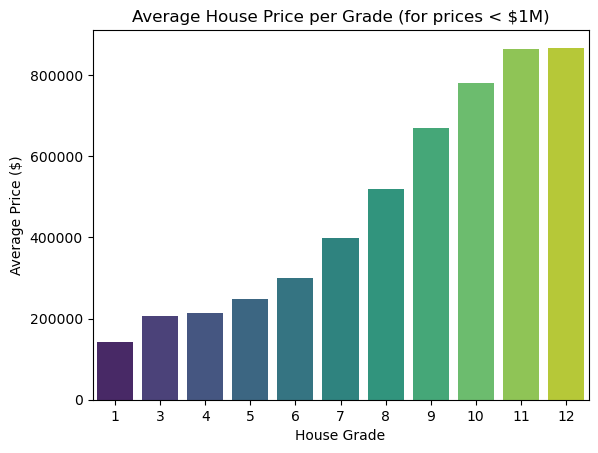

In [79]:
# Group by 'grade' and calculate the mean price, then round it

avg_price_per_grade_less_1e6 = price_equals_less_1e6.groupby("grade")["price"].mean().round()
avg_price_per_grade_less_1e6 = avg_price_per_grade_less_1e6.reset_index()


sns.barplot(
    x="grade",
    y="price",
    data=avg_price_per_grade_less_1e6,
    palette="viridis",
)

# Set the plot title and labels
plt.title('Average House Price per Grade (for prices < $1M)')
plt.xlabel('House Grade')
plt.ylabel('Average Price ($)')
plt.show()

   waterfront     price
0           0  467365.0
1           1  659007.0


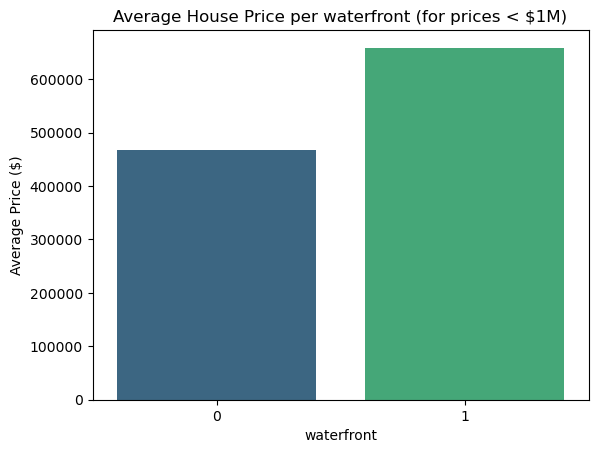

In [82]:
#Group by 'waterfront' and calculate the mean price, then round it

avg_price_per_wf_less_1e6 = price_equals_less_1e6.groupby("waterfront")["price"].mean().round()
avg_price_per_wf_less_1e6 = avg_price_per_wf_less_1e6.reset_index()

print(avg_price_per_wf_less_1e6)
sns.barplot(
    x="waterfront",
    y="price",
    data=avg_price_per_wf_less_1e6,
    palette="viridis"
)

# Set the plot title and labels
plt.title('Average House Price per waterfront (for prices < $1M)')
plt.xlabel('waterfront')
plt.ylabel('Average Price ($)')
plt.show()

   view     price
4     4  728216.0
3     3  623790.0
1     1  605550.0
2     2  602130.0
0     0  455956.0


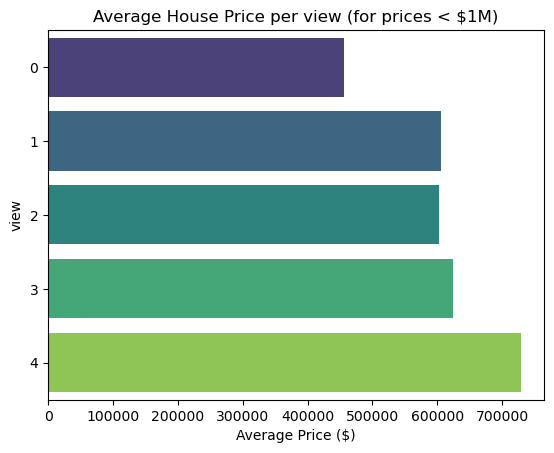

In [89]:
#Group by 'view' and calculate the mean price, then round it

avg_price_per_view_less_1e6 = price_equals_less_1e6.groupby("view")["price"].mean().round()
avg_price_per_view_less_1e6 = avg_price_per_view_less_1e6.reset_index()


# Sort the DataFrame by 'price' in descending order for a better visual distinction in the plot
avg_price_per_view_less_1e6 = avg_price_per_view_less_1e6.sort_values("price", ascending=False)

print(avg_price_per_view_less_1e6)
sns.barplot(
    x="price",
    y="view",
    data=avg_price_per_view_less_1e6,
    palette="viridis", 
    orient="h"
)

# Set the plot title and labels
plt.title('Average House Price per view (for prices < $1M)')
plt.xlabel('Average Price ($)')
plt.ylabel('view')
plt.show()

   condition     price
0          1  288855.0
1          2  305490.0
2          3  470639.0
3          4  457668.0
4          5  501644.0


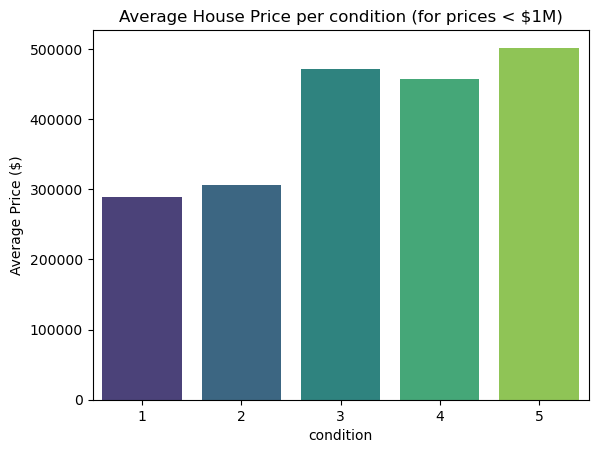

In [84]:
#Group by 'condition' and calculate the mean price, then round it

avg_price_per_condition_less_1e6 = price_equals_less_1e6.groupby("condition")["price"].mean().round()
avg_price_per_condition_less_1e6 = avg_price_per_condition_less_1e6.reset_index()

print(avg_price_per_condition_less_1e6)
sns.barplot(
    x="condition",
    y="price",
    data=avg_price_per_condition_less_1e6,
    palette="viridis"
)

# Set the plot title and labels
plt.title('Average House Price per condition (for prices < $1M)')
plt.xlabel('condition')
plt.ylabel('Average Price ($)')
plt.show()

## zipcode analysis

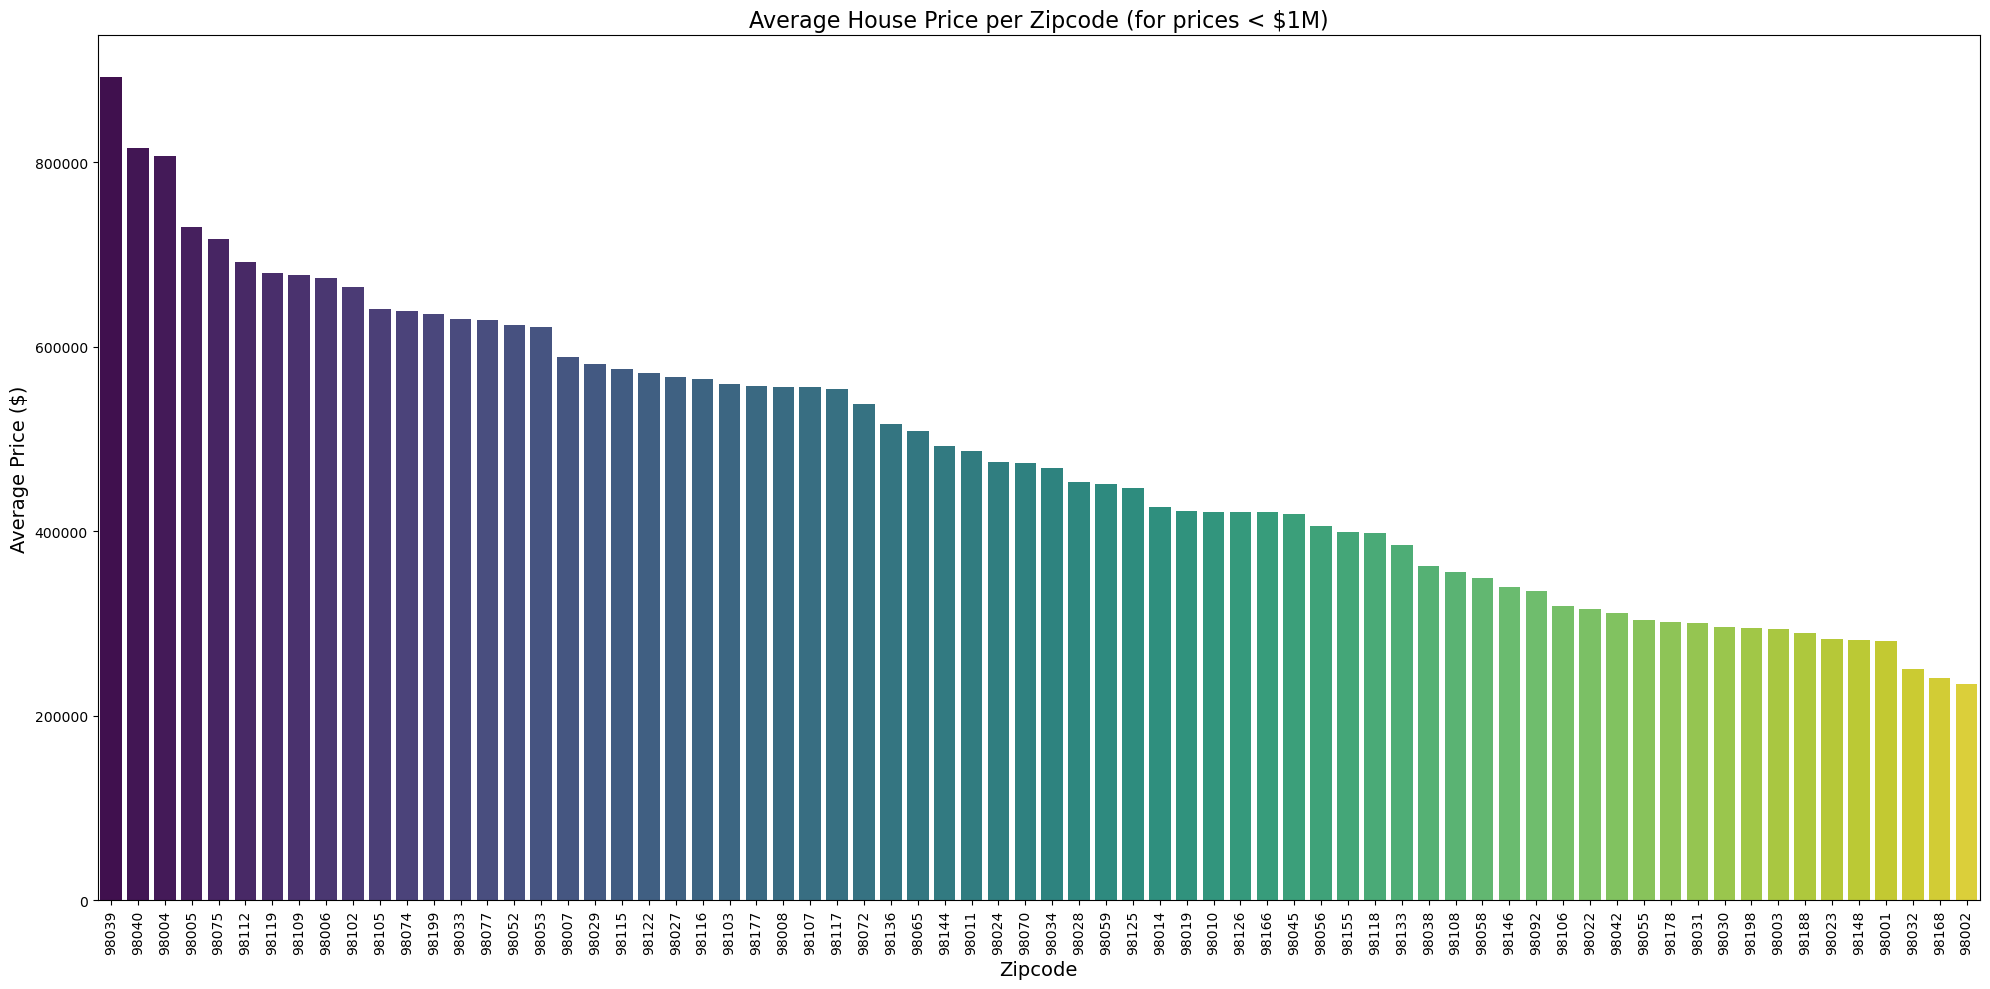

In [99]:
# Group by 'zipcode' and calculate the mean price, then round it

avg_price_per_zipcode_less_1e6 = price_equals_less_1e6.groupby("zipcode")["price"].mean().round()
avg_price_per_zipcode_less_1e6 = avg_price_per_zipcode_less_1e6.reset_index()


# Convert 'zipcode' to string as it's not already but to be included in the wrangle function
avg_price_per_zipcode_less_1e6['zipcode'] = avg_price_per_zipcode_less_1e6['zipcode'].astype(str)
# avg_price_per_zipcode_less_1e6 = avg_price_per_zipcode_less_1e6.sort_values("price", ascending=False)

# Assuming avg_price_per_zipcode_less_1e6 is defined and contains the average prices per zipcode

# Increase the size of the plot
plt.figure(figsize=(20, 10))

# Create a bar plot
sns.barplot(
    x='zipcode',
    y='price',
    data=avg_price_per_zipcode_less_1e6.sort_values('price', ascending=False),  # Sort values for better visualization
    palette='viridis'
)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Set the plot title and labels with larger font size
plt.title('Average House Price per Zipcode (for prices < $1M)', fontsize=16)
plt.xlabel('Zipcode', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()


In [67]:
price_equals_less_1e6_with_wf = price_equals_less_1e6[price_equals_less_1e6["waterfront"] == 1]

In [68]:
price_equals_less_1e6_with_wf.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
230,655000.0,2,1.75,1450,15798,2.0,1,4,3,7,220,1915,1978,98166,47.4497,-122.375,2030,13193,2015,4,13
264,369900.0,1,0.75,760,10079,1.0,1,4,5,5,0,1936,0,98070,47.4683,-122.438,1230,14267,2014,10,27
457,705000.0,3,3.00,1970,20978,2.0,1,3,4,9,200,1980,0,98070,47.3844,-122.438,2280,75396,2014,11,26
1081,825000.0,2,1.00,1150,12775,1.0,1,4,4,6,0,1908,0,98178,47.5020,-122.222,2440,11852,2014,8,27
1157,790000.0,4,1.75,2460,10061,1.0,1,4,3,7,1050,1961,0,98178,47.5105,-122.238,2300,10061,2014,12,29


In [69]:
price_equals_less_1e6_with_wf.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
count,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.0,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,659007.491525,2.813559,1.961864,1989.20339,33659.169492,1.423729,1.0,3.627119,3.593220,7.254237,368.966102,1948.983051,471.288136,98121.474576,47.435134,-122.374729,1955.627119,28266.288136,2014.254237,6.949153,19.067797
std,205554.327899,1.041792,0.892755,794.42744,67856.669032,0.498390,0.0,0.692280,0.768309,1.138560,465.575616,24.219892,852.217757,58.505336,0.069751,0.094117,576.894716,31486.952867,0.439169,3.245282,7.910849
min,285000.000000,1.000000,0.750000,440.00000,1989.000000,1.000000,1.0,1.000000,1.000000,5.000000,0.000000,1903.000000,0.000000,98006.000000,47.327600,-122.514000,750.000000,2433.000000,2014.000000,1.000000,1.000000
25%,511500.000000,2.000000,1.000000,1455.00000,11390.000000,1.000000,1.0,3.000000,3.000000,6.500000,0.000000,1930.000000,0.000000,98070.000000,47.379050,-122.445500,1605.000000,11897.000000,2014.000000,4.500000,13.000000
50%,650000.000000,3.000000,1.750000,1990.00000,17635.000000,1.000000,1.0,4.000000,4.000000,7.000000,0.000000,1950.000000,0.000000,98136.000000,47.449900,-122.377000,1970.000000,16630.000000,2014.000000,7.000000,20.000000
75%,810000.000000,3.000000,2.500000,2520.00000,27962.500000,2.000000,1.0,4.000000,4.000000,8.000000,682.000000,1965.000000,0.000000,98178.000000,47.498250,-122.324500,2345.000000,32193.500000,2014.500000,10.000000,27.000000
max,1000000.000000,6.000000,4.500000,4380.00000,505166.000000,3.000000,1.0,4.000000,5.000000,10.000000,1430.000000,2007.000000,2003.000000,98198.000000,47.645000,-122.084000,3270.000000,192268.000000,2015.000000,12.000000,30.000000


<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


<Axes: xlabel='waterfront', ylabel='Count'>

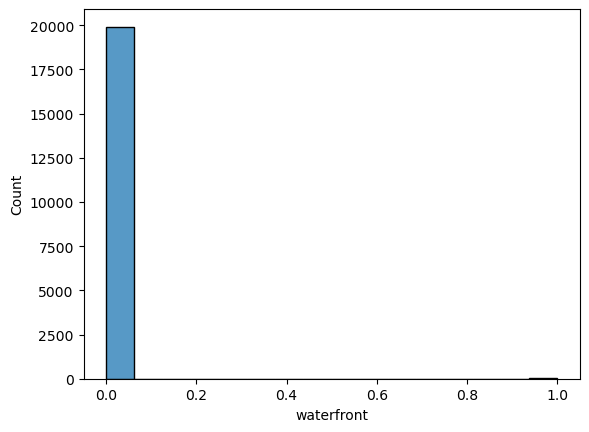

In [64]:
sns.histplot(price_equals_less_1e6["waterfront"] == 1)

In [39]:
#Handling outliers for "price" - here we are just checking extreme values
price_Q1 = df["price"].quantile(0.25)
price_Q3 = df["price"].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)

outliers_df = df[(df["price"] < lower_bound) | (df["price"] > upper_bound)]

outliers_df["price"].describe().apply("{0:,.0f}".format)

count        1,139
mean     1,667,952
std        653,911
min      1,130,000
25%      1,260,250
50%      1,450,000
75%      1,815,000
max      7,700,000
Name: price, dtype: object

In [ ]:
# Handling outliers for 'price' - here we are just checking for extreme values
price_Q1 = df['price'].quantile(0.25)
price_Q3 = df['price'].quantile(0.75)
price_IQR = price_Q3 - price_Q1
lower_bound = price_Q1 - (1.5 * price_IQR)
upper_bound = price_Q3 + (1.5 * price_IQR)
outliers_df = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]

# Dropping the extreme outliers for 'price'
df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Checking the new shape of the dataset after cleaning
new_shape = df.shape

In [ ]:
# # Convert 'zipcode' to a string format
# df['zipcode'] = df['zipcode'].astype(str)

In [ ]:
zipcode_avg_price = df.groupby('zipcode')['price'].mean()#.sort_values(ascending=False)


In [ ]:
# Prepare the data for feature enginnering
geo_data = df[['zipcode', 'lat', 'long']].drop_duplicates()
geo_data['avg_price'] = geo_data['zipcode'].map(zipcode_avg_price)

# Scale the features
scaler = StandardScaler()
geo_data_scaled = scaler.fit_transform(geo_data[['lat', 'long', 'avg_price']])

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
geo_data['cluster'] = kmeans.fit_predict(geo_data_scaled)

# Create a mapping from zipcode to cluster
zipcode_to_cluster = geo_data.set_index('zipcode')['cluster'].to_dict()

# Map the geographic groupings back to the original properties
df['geo_group'] = df['zipcode'].map(zipcode_to_cluster)


In [ ]:
df.head()

In [ ]:
# Assuming df is your DataFrame and 'bathrooms' is the column of interest
df['full_bathrooms'] = df['bathrooms'].apply(lambda x: int(x))  # Full bathrooms are the integer part
df['half_bathrooms'] = df['bathrooms'].apply(lambda x: (x - int(x)) * 2)  # Half bathrooms are the fractional part, multiplied by 2

# Create a feature for unusual bathroom counts
df['unusual_bath_count'] = df['bathrooms'].isin([0, 0.75]).astype(int)

# Investigate properties with 0 bathrooms
properties_with_no_bathrooms = df[df['bathrooms'] == 0]

In [ ]:
corr_matrix = df.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[['price']].sort_values(by='price', ascending=False), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix with Price Including Date Features')
plt.show()